In [53]:
from dataclasses import dataclass
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import re

# Loading Benchmarks Results

In [40]:
@dataclass
class BenchmarkResult:
    benchmark_name: str
    tool: str
    total_durations: int # In milliseconds
    is_realizable: bool
    total_states: int
    is_completed: bool

    @staticmethod
    def read_from_hoa(hoa_filepath: str):
        hoa = Path(hoa_filepath).read_text()
        
        total_duration_rgx = "Total Duration:\s*(\d+[.]?\d*)"
        tool_name_rgx = "Tool:\s*(.*)[*]"
        total_states_rgx = "States:\s*(\d+)"
        benchmark_name = Path(hoa_filepath).stem
        
        is_completed = ("REALIZABLE" in hoa) or ("UNREALIZABLE" in hoa)
        total_duration = float(re.search(total_duration_rgx, hoa).group(1))
        tool_name = re.search(tool_name_rgx, hoa).group(1)
        
        is_realizable = not("UNREALIZABLE" in hoa) if is_completed else None
        total_states = re.search(total_states_rgx, hoa).group(1) if is_realizable else None
    
        return BenchmarkResult(
            benchmark_name, tool_name.strip(), total_duration,
            is_realizable, total_states, is_completed
        )

In [41]:
algorithms_output_path = glob("../outputs-synt/*")
algorithms = [ Path(path).stem for path in algorithms_output_path]

In [42]:
algorithms_benchmarks = {}
for algo, outputs_path in zip(algorithms, algorithms_output_path):
    benchmarks_path = glob(f"{outputs_path}/*")
    benchmarks = [ BenchmarkResult.read_from_hoa(benchmark) for benchmark in benchmarks_path]
    algorithms_benchmarks[algo] = benchmarks

In [43]:
all_benchmarks_dict = []
for algo, benchmarks in algorithms_benchmarks.items():
    for benchmark in benchmarks:
        all_benchmarks_dict.append(benchmark.__dict__)
benchmarks_df = pd.DataFrame(all_benchmarks_dict)
benchmarks_df.head()

,benchmark_name,tool,total_durations,is_realizable,total_states,is_completed
0,TwoCountersInRangeA4,ltlsynt-ds,6892.819,False,None,True
1,ltl2dba05,ltlsynt-ds,20.461,True,5,True
2,ltl2dba11,ltlsynt-ds,23.871,True,1,True
3,TwoCountersDisButA6,ltlsynt-ds,2401558.201,None,None,False
4,TorcsSteeringSimple,ltlsynt-ds,24.025,True,1,True


# Overview Benchmarks

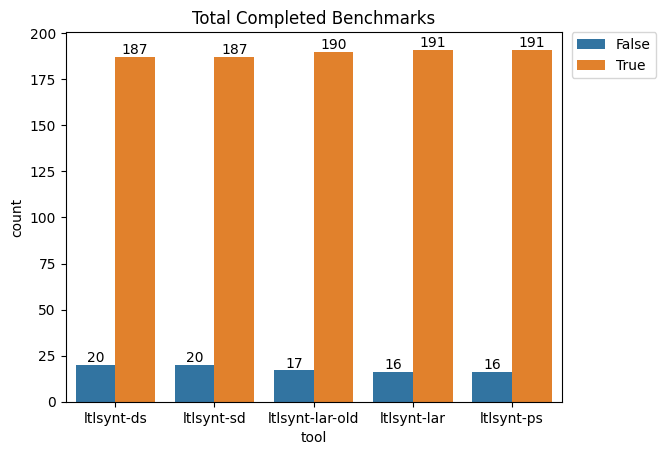

In [56]:
ax = sns.countplot(x="tool", data=benchmarks_df, hue="is_completed")
for container in ax.containers: ax.bar_label(container)
ax.set_title("Total Completed Benchmarks")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);